In [1]:
from pyspark.sql import SparkSession

In [2]:
spark: SparkSession = SparkSession.builder.appName("ExampleApp").getOrCreate()

In [3]:
df = spark.read.parquet("data/2017_StPaul_MN_Real_Estate.parquet")

In [4]:
df = df.select(["StreetNumberNumeric", "FirePlaces", "LotSizeDimensions", "ListType", "Acres"])
df.show()

+-------------------+----------+--------------------+---------------+-----+
|StreetNumberNumeric|FirePlaces|   LotSizeDimensions|       ListType|Acres|
+-------------------+----------+--------------------+---------------+-----+
|              11511|         0|             279X200|Exclusive Right| 1.28|
|              11200|         0|             100x140|Exclusive Right| 0.32|
|               8583|         0|             120x296|Exclusive Right|0.822|
|               9350|         1|             208X208|Exclusive Right| 0.94|
|               2915|         1|             116x200|Exclusive Right|  0.0|
|               3604|         1|              50x150|Exclusive Right|0.172|
|               9957|         0|              common|Exclusive Right| 0.05|
|               9934|         0|              common|Exclusive Right| 0.05|
|               9926|         0|              common|Exclusive Right| 0.05|
|               9928|         0|              common|Exclusive Right| 0.05|
|           

In [5]:
cols_to_drop = ['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS']
df = df.drop(*cols_to_drop)

In [6]:
df.show(5)

+----------+---------------+-----+
|FirePlaces|       ListType|Acres|
+----------+---------------+-----+
|         0|Exclusive Right| 1.28|
|         0|Exclusive Right| 0.32|
|         0|Exclusive Right|0.822|
|         1|Exclusive Right| 0.94|
|         1|Exclusive Right|  0.0|
+----------+---------------+-----+
only showing top 5 rows



In [7]:
df = spark.read.parquet("data/2017_StPaul_MN_Real_Estate.parquet")
print(df.count())

5000


In [8]:
df.select(['ASSUMABLEMORTGAGE']).distinct().show()

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|Yes w/No Qualifying|
|      Not Assumable|
|               NULL|
+-------------------+



In [9]:
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']
text_filter = ~df['ASSUMABLEMORTGAGE'].isin(yes_values) | df['ASSUMABLEMORTGAGE'].isNull()
df = df.where(text_filter)
print(df.count())

4976


In [10]:
from pyspark.sql.functions import log
df = df.withColumn('log_SalesClosePrice', log(df['SalesClosePrice']))

In [11]:
from pyspark.sql.functions import mean, stddev


mean_val = df.agg({'log_SalesClosePrice': 'mean'}).collect()[0][0]
stddev_val = df.agg({'log_SalesClosePrice': 'stddev'}).collect()[0][0]

low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df = df.where((df['log_SalesClosePrice'] < hi_bound) & (df['log_SalesClosePrice'] > low_bound))

In [12]:
print(df.count())

4946


In [13]:
from pyspark.sql.functions import round

In [14]:
# Define max and min values and collect them
max_days = df.agg({'DAYSONMARKET': 'max'}).collect()[0][0]
min_days = df.agg({'DAYSONMARKET': 'min'}).collect()[0][0]

# Create a new column based off the scaled data
df = df.withColumn('percentage_scaled_days', 
                  round((df['DAYSONMARKET'] - min_days) / (max_days - min_days)) * 100)

# Calc max and min for new column
print(df.agg({'percentage_scaled_days': 'max'}).collect())
print(df.agg({'percentage_scaled_days': 'min'}).collect())

[Row(max(percentage_scaled_days)=100.0)]
[Row(min(percentage_scaled_days)=0.0)]


In [15]:
cols_to_scale = ['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES']

In [16]:
def min_max_scaler(df, cols_to_scale):
  # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
  for col in cols_to_scale:
    # Define min and max values and collect them
    max_days = df.agg({col: 'max'}).collect()[0][0]
    min_days = df.agg({col: 'min'}).collect()[0][0]
    new_column_name = 'scaled_' + col
    # Create a new column based off the scaled data
    df = df.withColumn(new_column_name, 
                      (df[col] - min_days) / (max_days - min_days))
  return df
  
df = min_max_scaler(df, cols_to_scale)
# Show that our data is now between 0 and 1
df[['DAYSONMARKET', 'scaled_DAYSONMARKET']].show()

+------------+--------------------+
|DAYSONMARKET| scaled_DAYSONMARKET|
+------------+--------------------+
|          10|0.044444444444444446|
|           4|0.017777777777777778|
|          28| 0.12444444444444444|
|          19| 0.08444444444444445|
|          21| 0.09333333333333334|
|          17| 0.07555555555555556|
|          32| 0.14222222222222222|
|           5|0.022222222222222223|
|          23| 0.10222222222222223|
|          73|  0.3244444444444444|
|          80| 0.35555555555555557|
|          79|  0.3511111111111111|
|          12| 0.05333333333333334|
|           1|0.004444444444444...|
|          18|                0.08|
|           2|0.008888888888888889|
|          12| 0.05333333333333334|
|          45|                 0.2|
|          31| 0.13777777777777778|
|          16| 0.07111111111111111|
+------------+--------------------+
only showing top 20 rows



In [17]:
from pyspark.sql.functions import log

# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

# Calculate the max year
max_year = df.agg({'YEARBUILT': 'max'}).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df = df.withColumn('adj_yearbuilt', 1 / log(df['Reflect_YearBuilt']))

[Row(skewness(YEARBUILT)=-0.25317374723020336)]


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
columns = ['APPLIANCES', 'BACKONMARKETDATE', 'ROOMFAMILYCHAR', 'BASEMENT', 'DININGROOMDESCRIPTION']

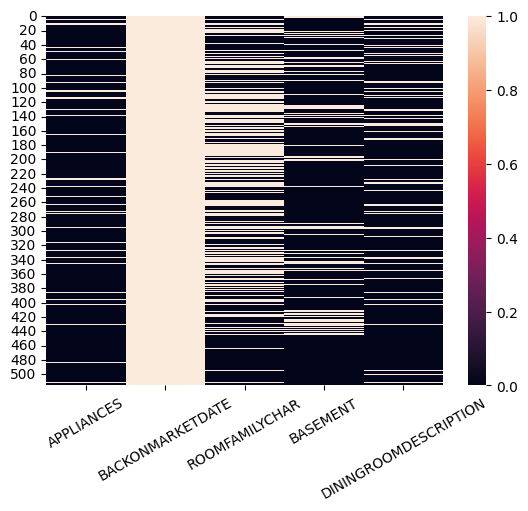

In [20]:
sample_df = df.select(columns).sample(False, 0.1, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()

# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

# Set the answer to the column with the most missing data
answer = 'BACKONMARKETDATE'

In [21]:
# Count missing rows
missing = df.where(df['PDOM'].isNull()).count()

# Calculate the mean value
col_mean = df.agg({'PDOM': 'mean'}).collect()[0][0]

# Replacing with the mean value for that column
df.fillna(col_mean, subset=['PDOM'])

DataFrame[No.: bigint, MLSID: string, StreetNumberNumeric: bigint, streetaddress: string, STREETNAME: string, PostalCode: bigint, StateOrProvince: string, City: string, SalesClosePrice: bigint, LISTDATE: string, LISTPRICE: bigint, LISTTYPE: string, OriginalListPrice: bigint, PricePerTSFT: double, FOUNDATIONSIZE: bigint, FENCE: string, MapLetter: string, LotSizeDimensions: string, SchoolDistrictNumber: string, DAYSONMARKET: bigint, offmarketdate: string, Fireplaces: bigint, RoomArea4: string, roomtype: string, ROOF: string, RoomFloor4: string, PotentialShortSale: string, PoolDescription: string, PDOM: bigint, GarageDescription: string, SQFTABOVEGROUND: bigint, Taxes: bigint, RoomFloor1: string, RoomArea1: string, TAXWITHASSESSMENTS: double, TAXYEAR: bigint, LivingArea: bigint, UNITNUMBER: string, YEARBUILT: bigint, ZONING: string, STYLE: string, ACRES: double, CoolingDescription: string, APPLIANCES: string, backonmarketdate: double, ROOMFAMILYCHAR: string, RoomArea3: string, EXTERIOR: s

In [22]:
def column_dropper(df, threshold):
  # Takes a dataframe and threshold for missing values. Returns a dataframe.
  total_records = df.count()
  for col in df.columns:
    # Calculate the percentage of missing values
    missing = df.where(df[f'`{col}`'].isNull()).count()
    missing_percent = missing / total_records
    # Drop column if percent of missing is more than threshold
    if missing_percent > threshold:
      df = df.drop(col)
  return df

# Drop columns that are more than 60% missing
df = column_dropper(df, .6)

## Join df

In [24]:
# # Cast data types
# walk_df = walk_df.withColumn('longitude', walk_df['longitude'].cast('double'))
# walk_df = walk_df.withColumn('latitude', walk_df['latitude'].cast('double'))

# # Round precision
# df = df.withColumn('longitude', round(df['longitude'], 5))
# df = df.withColumn('latitude', round(df['latitude'], 5))

# # Create join condition
# condition = [(df['longitude'] == walk_df['longitude']), (df['latitude'] == walk_df['latitude'])]

# # Join the dataframes together
# join_df = df.join(walk_df, on=condition, how='left')
# # Count non-null records from new field
# print(join_df.where(~join_df['walkscore'].isNull()).count())

## Join df by SQL

In [25]:
# # Register dataframes as tables
# df.createOrReplaceTempView("df")
# walk_df.createOrReplaceTempView("walk_df")

# # SQL to join dataframes
# join_sql = 	"""
# 			SELECT 
# 				*
# 			FROM df
# 			LEFT JOIN walk_df
# 			ON df.longitude = walk_df.longitude
# 			AND df.latitude = walk_df.latitude
# 			"""
# # Perform sql join
# joined_df = spark.sql(join_sql)